# Analyse dsync Notebook

## Abstract

TODO

## Experiences

Les experiences on été mené sur 3 sessions *data-yyyy-mm-dd* à chaque session correspond une série d'expérience *n__d_yyyy_mm_dd_t_hh_mm_ss* 
Il y a 6 musiciens et chaque musicien participant à l'expérience on 2 dispositifs d'acquisition (**riots**), un toujours sur la tête et l'autre au bras ou à la jambe suivant la session. Il y a donc un total de 12 dispositifs d'acquisition dans une expérience.

Un dispositif d'acquisition dispose de :

* 3 capteurs  : accelerometre (**acc**) gyroscope (**gyro**) et magnetometre (**mag**) sur 3 axes chacun
* 3 metrics : 
  * **orientation** sur 3 axes, angle du dispositif par rapport à l'axe de gravitation
  * acceleration filtré (**accfilt**) sur 3 axes, filtre passe bas (~10 Hz) pour les données de l'accelerometre pour éliminer les micro variations indésirable
  * **intensity**, normalisation de la quantité de mouvement, représentation "adouci" du mouvement enregistré

Il y a donc au total 16 metrics par dispositif par musicien.

un fichier son  de la performance, suivant la session il inclu le son d'un metronome

une vidéo de la performance

un fichier *riots-musicians.txt* qui assoscie chaque riot à un musicien ainsi que son type 

Une session comprend aussi des enrigistrement de calibration, des improvisations et des tests

## Datas

Stocké au format *.txt* pour chaque riots, échantilloné à 10ms, les données comprennent :

| Time Stamp | acc_x | acc_y | acc_z | gyro_x | gyro_y | gyro_z | mag_x | mag_y | mag_z | orientation_x | orientation_y | orientation_z | accfilt_x | accfilt_y | accfilt_z | intensity |
| ---------- | ----- | ----- | ----- | ------ | ------ | ------ | ----- | ----- | ----- | ------------- | ------------- | ------------- | --------- | --------- | --------- | --------- |

Les données doivent être tronqué dans le temps car elles comprennes des données biaisé avant et après la performance.

## Code 

### Imports

[pandas](https://pandas.pydata.org/) Pour manipulé des ensemble de donnée avec des DataFrame
[matplotlib]() pour la visualisation de donnée
[seaborn]() pour réaliser des graphs plus fancy

In [1]:
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
 
sns.set_theme(style="darkgrid")

### Data structures

Les structures de données doivent avoir une organisation scalable, optimisé pour éviter les redondances et pour accélérer la recherche, la structure est "trivial" pour les autres language de programmation plus bas niveau
Les structures de données peuvent s'organiser comme suit :

* class Session:
    * date: string (date)
    * experiences: dict of Experience

* class Experience:
    * time: string (time)
    * number: int
    * musician_riots: dictionary { musician: (riot_head, riot_limb) }
    * riots: dict of Riot (avant list)

* class Riot:
    * dataset: dict Dataset (avant list)
    * duration : float
    * trunc: (start: float, end: float)
    * riot_type: "arm" | "leg" | "head"

* class Dataset:
    * t: float
    * acc_x: float
    * acc_y: float
    * acc_z: float
    * gyro_x: float
    * gyro_y: float
    * gyro_z: float
    * mag_x: float
    * mag_y: float
    * mag_z: float
    * orientation_x: float
    * orientation_y: float
    * orientation_z: float
    * accfilt_x: float
    * accfilt_y: float
    * accfilt_z: float
    * intensity: float

In [2]:
class Session:
    def __init__(self, date, experiences=None):
        self.date = date
        if(experiences is None):
            experiences = {}
        self.experiences = experiences

class Experience:
    def __init__(self, time, number,musician_riots={}, riots=None):
        self.time = time
        self.number = number
        # WARNING : Mutable default argument, all instance of experience point on the same instance of musician_riots dictionnary
        self.musician_riots = musician_riots
        if(riots is None):
            riots = {}
        self.riots = riots

class Riot:
    def __init__(self, dataset, duration, trunc, riot_type):
        self.dataset = dataset
        self.duration = duration
        self.trunc = trunc
        self.riot_type = riot_type

class Dataset:
    def __init__(self, t, acc_x, acc_y, acc_z, gyro_x, gyro_y, gyro_z, mag_x, mag_y, mag_z, orientation_x, orientation_y, orientation_z, accfilt_x, accfilt_y, accfilt_z, intensity):
        self.t = t
        self.acc_x = acc_x
        self.acc_y = acc_y
        self.acc_z = acc_z
        self.gyro_x = gyro_x
        self.gyro_y = gyro_y
        self.gyro_z = gyro_z
        self.mag_x = mag_x
        self.mag_y = mag_y
        self.mag_z = mag_z
        self.orientation_x = orientation_x
        self.orientation_y = orientation_y
        self.orientation_z = orientation_z
        self.accfilt_x = accfilt_x
        self.accfilt_y = accfilt_y
        self.accfilt_z = accfilt_z
        self.intensity = intensity
        
    def __str__(self):
        return f"t: {self.t}, acc_x: {self.acc_x}, acc_y: {self.acc_y}, acc_z: {self.acc_z}, gyro_x: {self.gyro_x}, gyro_y: {self.gyro_y}, gyro_z: {self.gyro_z}, mag_x: {self.mag_x}, mag_y: {self.mag_y}, mag_z: {self.mag_z}, orientation_x: {self.orientation_x}, orientation_y: {self.orientation_y}, orientation_z: {self.orientation_z}, accfilt_x: {self.accfilt_x}, accfilt_y: {self.accfilt_y}, accfilt_z: {self.accfilt_z}, intensity: {self.intensity}"


### Datas loading

In [3]:
import os
import re
import glob

from watchpoints import watch

def load_data(session_folder):
    # Extract date from folder name
    date = session_folder.split('-',1)[-1]
    session = Session(date)
    
    musicians_info_path = os.path.join(session_folder, 'riots-musicians.txt')
    musician_info = {}
    musician_riots = {}

    # Charger les infos des musiciens et des riots
    with open(musicians_info_path, 'r') as file:
        for line in file:
            riot_number, musician, riot_type = line.strip().split()
            musician_info[int(riot_number)-1] = (musician, riot_type)
            
           # Vérifier si le musicien est déjà dans le dictionnaire
            if musician not in musician_riots:
                # Initialiser un tuple pour 'head' et 'arm/leg' avec None
                musician_riots[musician] = (None, None)
            
            if riot_type == 'head':
                # Mettre à jour le numéro de riot pour 'head'
                musician_riots[musician] = (int(riot_number)-1, musician_riots[musician][1])
            elif riot_type in ['arm', 'leg']:
                # Mettre à jour le numéro de riot pour 'arm/leg' si ce n'est pas déjà fait
                if musician_riots[musician][1] is None:
                    musician_riots[musician] = (musician_riots[musician][0], int(riot_number)-1)
    
    # Charger les données des expériences
    for exp_file in glob.glob(f'{session_folder}/*-data-riot-*.txt'):
        exp_info = os.path.basename(exp_file).split('_')
        exp_number = int(exp_info[0])
        exp_time = re.search(r't_(\d+_\d+_\d+)-data', exp_file).group(1).replace('_', ':')
        riot_number = int(exp_info[-1].split('.')[0].split('-')[-1]) - 1
        
        experience = None
        # print("exp",exp_number)
        if exp_number in session.experiences:
            experience = session.experiences[exp_number]
        else:
            experience = Experience(exp_time,exp_number)
            experience.musician_riots = musician_riots
            session.experiences[exp_number] = experience
        
        # Lecture des données du riot
        datasets = []
        with open(exp_file, 'r') as file:
            for line in file:
                data = list(map(float, line.strip().split()))
                dataset = Dataset(*data)
                datasets.append(dataset)
        
        # Calculer la durée comme le max de t
        duration = max([d.t for d in datasets])
        
        riot = Riot(datasets, duration, (0, duration), musician_info[riot_number][1])
        session.experiences[exp_number].riots[riot_number] = riot
        
    return session
    
data_folder = "../data/"
session2_folder = data_folder + 'data-2023-09-27'

session = load_data(session2_folder)


### Building Dataframe 

TODO

class Dataf (extend Dataset): 
  * exp_n: int
  * riot_n: int
  * musician: string
  * riot_type: "arm" | "leg" | "head"

In [4]:
class Dataf(Dataset):
    def __init__(self,dataset,exp_n,riot_n,musician,riot_type):
        Dataset.__init__(self,dataset.t,dataset.acc_x,dataset.acc_y,dataset.acc_z,dataset.gyro_x,dataset.gyro_y,dataset.gyro_z,dataset.mag_x,dataset.mag_y,dataset.mag_z,dataset.orientation_x,dataset.orientation_y,dataset.orientation_z,dataset.accfilt_x,dataset.accfilt_y,dataset.accfilt_z,dataset.intensity)
        self.exp_n = exp_n
        self.riot_n = riot_n
        self.musician = musician
        self.riot_type = riot_type

In [5]:
def session_to_dataf(session):
    # Construire les objets Dataf
    datasetsf = []
    # for exp in session.experiences:
    #     for riot in exp.riots:
    #         dataf_list = [Dataf(dataset,exp.number,riot.key,musician,riot.riot_type) for dataset in riot.dataset]
    for exp in session.experiences:      
        experience = session.experiences[exp]
        for musician in list(experience.musician_riots.keys()):
            riot_head, riot_limb = experience.musician_riots[musician]
            datasetsf = datasetsf + [Dataf(data,experience.number,riot_head,musician,experience.riots[riot_head].riot_type) for data in experience.riots[riot_head].dataset]
            datasetsf = datasetsf + [Dataf(data,experience.number,riot_head,musician,experience.riots[riot_limb].riot_type) for data in experience.riots[riot_limb].dataset]
    
    # Utilisation de l'introspection pour construire la liste des dictionnaires
    data_dicts = [vars(dataset) for dataset in datasetsf]

    # Création du DataFrame Pandas
    return pd.DataFrame(data_dicts)
            

### Exemple

Display waveform of the intensity of Cello over time in experience 10

In [6]:
data_folder = "../data/"
session2_folder = data_folder + 'data-2023-09-27'

session = load_data(session2_folder)
df = session_to_dataf(session)

In [7]:
print(session.experiences[10].riots[0].dataset[0])

t: 1.099669225513935, acc_x: -0.437255859375, acc_y: -0.59228515625, acc_z: 0.6973876953125, gyro_x: -0.082550048828125, gyro_y: -0.00030517578125, gyro_z: -0.035552978515625, mag_x: 1.84881591796875, mag_y: 0.4600830078125, mag_z: 1.13043212890625, orientation_x: -0.42228183150291443, orientation_y: -0.35438215732574463, orientation_z: 0.8343209028244019, accfilt_x: 0.0024512477684766054, accfilt_y: -0.1477406620979309, accfilt_z: -0.05230892077088356, intensity: 0.10544366389513016


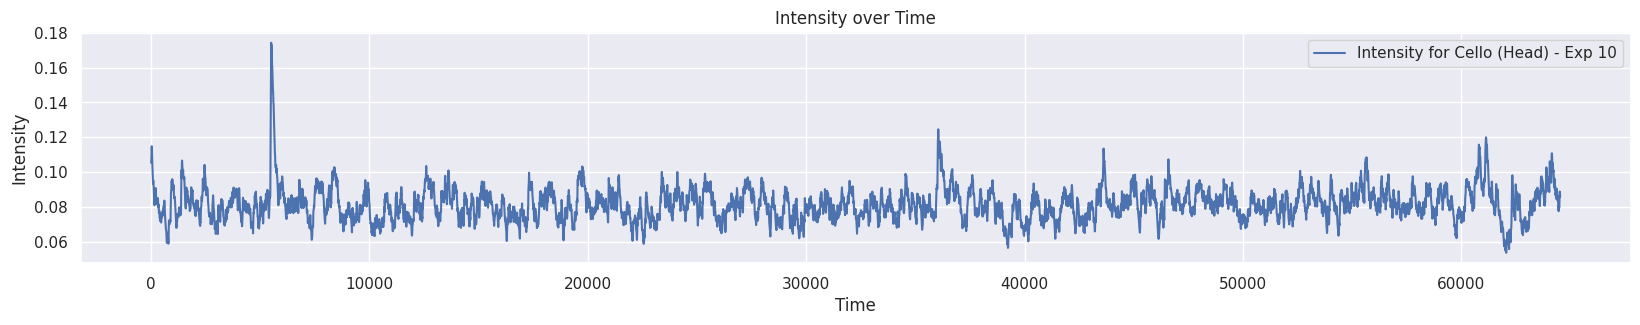

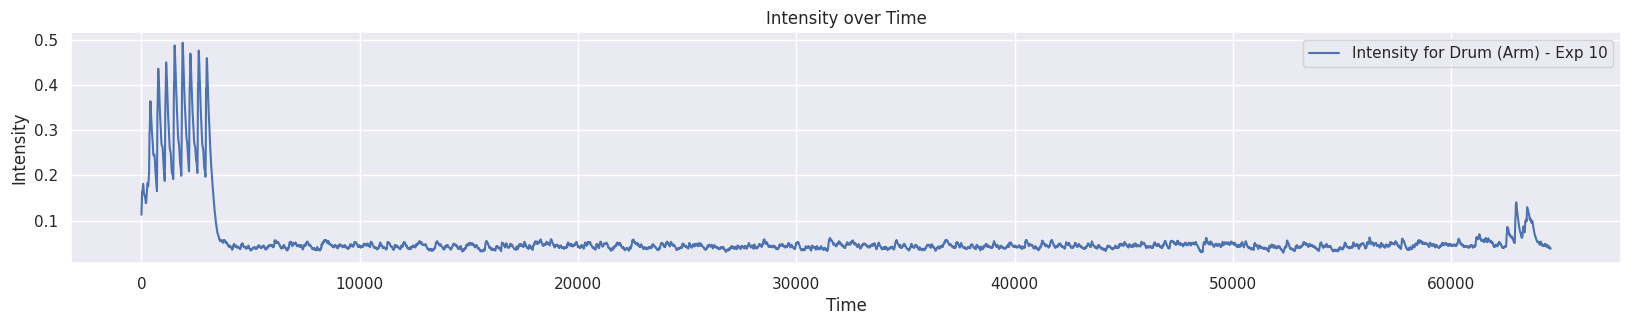

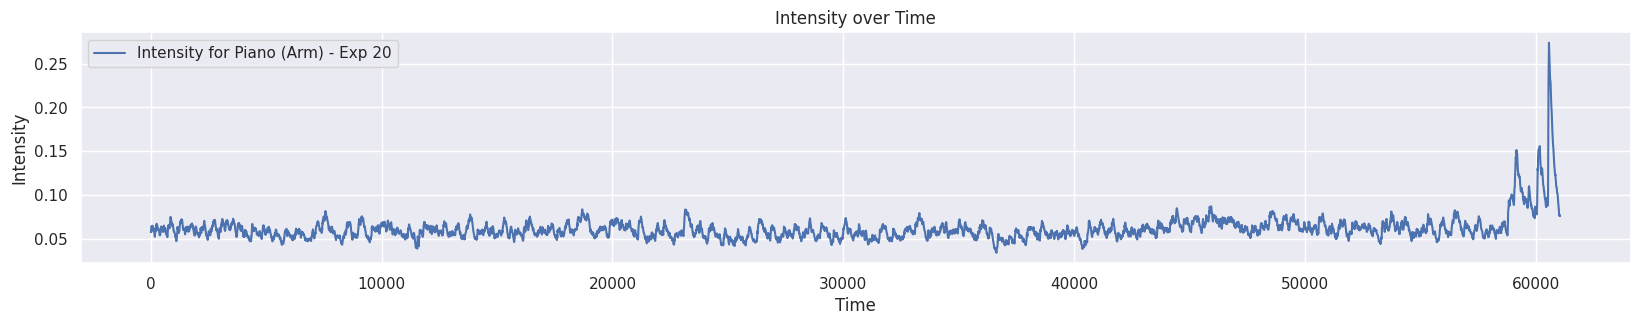

In [9]:
filtered_df_Cello = df[(df['musician'] == 'Cello') & (df['riot_type'] == 'head') & (df['exp_n'] == 10)]

plt.figure(figsize=(20, 3))
sns.lineplot(data=filtered_df_Cello, x='t', y='intensity', label='Intensity for Cello (Head) - Exp 10')
plt.title('Intensity over Time')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.legend()
plt.show()

filtered_df_Drum = df[(df['musician'] == 'Drum') & (df['riot_type'] == 'arm') & (df['exp_n'] == 10)]

plt.figure(figsize=(20, 3))
sns.lineplot(data=filtered_df_Drum, x='t', y='intensity', label='Intensity for Drum (Arm) - Exp 10')
plt.title('Intensity over Time')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.legend()
plt.show()

filtered_df_Piano = df[(df['musician'] == 'Piano') & (df['riot_type'] == 'arm') & (df['exp_n'] == 20)]

plt.figure(figsize=(20, 3))
sns.lineplot(data=filtered_df_Piano, x='t', y='intensity', label='Intensity for Piano (Arm) - Exp 20')
plt.title('Intensity over Time')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.legend()
plt.show()

## TODO

* mettre au propre l'association riots musicien position
* construction de la base de donnée